In [594]:
import pandas as pd
import json

# Decision Tree
Ho visto che il decision tree è il modello che mi offre migliori performance

In [595]:
dataset = pd.read_csv('completati/description_predictions.csv', index_col=0)

dataset_withoutNAN = dataset[dataset.prediction != 'NAN']
dataset_withoutNAN.reset_index(drop=True, inplace=True)

## Feature normalization
È necessaria la normalizzazione delle feature, dato che nel testo abbiamo i nomi delle squadre ed i soprannomi, vado a sostituire tutte le parole relative alla squadra di casa con home team e stessa cosa per la away team.

In [596]:
"""with open("sinonimi.json") as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

for i, row in dataset_withoutNAN[:2].iterrows():
    h_team, a_team, description, prediction = row.h_team, row.a_team, row.description, row.prediction

    syn = {}
    #cerco nel dizionario di sinonimi, tutti i sinonimi delle squadre del match
    for key in jsonObject.keys():
        if (h_team in key) or (key in h_team):
            syn['home team'] = jsonObject[key] 
            
        if (a_team in key) or (key in a_team):
            syn['away team'] = jsonObject[key] 

    #successivamente prendo il testo e sostituisco i sinonimi con home o away team
    description = description.lower()
    for key in syn.keys():
        for val in syn[key]:
            description = description.replace(val.lower(), key)

    dataset_withoutNAN.at[i, 'description'] = description"""

'with open("sinonimi.json") as jsonFile:\n    jsonObject = json.load(jsonFile)\n    jsonFile.close()\n\nfor i, row in dataset_withoutNAN[:2].iterrows():\n    h_team, a_team, description, prediction = row.h_team, row.a_team, row.description, row.prediction\n\n    syn = {}\n    #cerco nel dizionario di sinonimi, tutti i sinonimi delle squadre del match\n    for key in jsonObject.keys():\n        if (h_team in key) or (key in h_team):\n            syn[\'home team\'] = jsonObject[key] \n            \n        if (a_team in key) or (key in a_team):\n            syn[\'away team\'] = jsonObject[key] \n\n    #successivamente prendo il testo e sostituisco i sinonimi con home o away team\n    description = description.lower()\n    for key in syn.keys():\n        for val in syn[key]:\n            description = description.replace(val.lower(), key)\n\n    dataset_withoutNAN.at[i, \'description\'] = description'

In [597]:

dataset_withoutNAN = dataset_withoutNAN[['description', 'prediction']]
prediction_labels = {
    'N': 0,
    'V': 1,
    'P': 2
}

dataset_withoutNAN['prediction'] = dataset_withoutNAN['prediction'].map(prediction_labels)

## Prediction

In [598]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
#token = RegexpTokenizer(r'[a-zA-Z0-9]+')
token = RegexpTokenizer(r'[a-zA-Z]+')

In [599]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
def word_tokenization(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def regex(text):
    tokens = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_tokenization(text):
    tokens_text = []
    tokens_lemma = []
    for token in nlp(text):
        if not token.is_stop:
            tokens_text.append(token.text)
            tokens_lemma.append(token.lemma_)
    return tokens_text, tokens_lemma

In [600]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

cleaned_corpus = []
for doc in dataset_withoutNAN.description:
  ###+++++++++++NLTK+++++++++++++###
  doc_text = word_tokenization(doc)
  ###+++++++++++REGEX++++++++++++###
  #doc_text = regex(doc)
  ###+++++++++++SPACY++++++++++++###
  #doc_text, d = spacy_tokenization(doc)
  #_______with lemmatization_______#
  #doc_text = [word for word in d]
  #____with stemming (universal)___# 
  doc_text = [stemmer.stem(word) for word in doc_text]
  ###+++++++++++++++++++++++++###
  doc_text = ' '.join(doc_text)
  cleaned_corpus.append(doc_text)

In [601]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(2,2)) #vectorizer sarà il nostro modello da allenare
#vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (2,2), tokenizer = token.tokenize)
text_counts= vectorizer.fit_transform(cleaned_corpus)

In [617]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as mtr

accuracy = 0

while(accuracy < 0.79):
    X_train, X_test, y_train, y_test = train_test_split(
        text_counts, dataset_withoutNAN.prediction, test_size=0.2, shuffle=False)

    model = DecisionTreeClassifier()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    E = []

    report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    E = {
            'Accuracy': report['accuracy'],
            'Avg Precision (macro)': report['macro avg']['precision'],
            'Avg Recall (macro)': report['macro avg']['recall'],
            'Avg F1-score (macro)': report['macro avg']['f1-score'],
            'Avg Precision (weighted)': report['weighted avg']['precision'],
            'Avg Recall (weighted)': report['weighted avg']['recall'],
            'Avg F1-score (weighted)': report['weighted avg']['f1-score']
    }
    accuracy = report['accuracy']
    

In [618]:
pd.DataFrame.from_dict(E, orient='index').T

,Accuracy,Avg Precision (macro),Avg Recall (macro),Avg F1-score (macro),Avg Precision (weighted),Avg Recall (weighted),Avg F1-score (weighted)
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [604]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

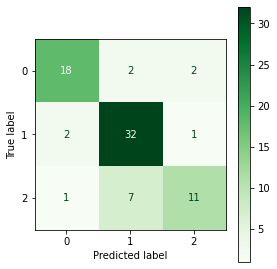

In [605]:
cm = mtr.confusion_matrix(y_test, y_pred)
d = mtr.ConfusionMatrixDisplay(cm, [prediction_labels[label] for label in prediction_labels.keys()])
fig, ax = plt.subplots(figsize=(4,4))
d.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

In [615]:
display((pd.DataFrame(y_test)))
print(y_pred)

,prediction
303,1
304,2
305,1
306,0
307,0
...,...
374,2
375,1
376,1
377,2


[1 2 1 1 2 1 0 1 1 0 0 1 2 1 1 0 1 1 1 2 1 1 1 1 0 2 1 0 1 2 0 0 1 2 1 1 2
 0 1 1 0 1 0 1 1 2 1 2 1 0 0 1 0 1 2 1 0 0 1 2 1 1 1 0 1 2 0 0 0 1 1 1 0 1
 2 1]


### Save model

In [606]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))


### Load model

In [607]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8026315789473685
